In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
import pandas as pd

# reading csv files
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/831/data/Facebook Ad Opt.csv', index_col=False)
df.head()

,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
0,708746,916,103916,30-34,M,15,7350,1,1.43,2,1
1,708749,916,103917,30-34,M,16,17861,2,1.82,2,0
2,708771,916,103920,30-34,M,20,693,0,0.00,1,0
3,708815,916,103928,30-34,M,28,4259,1,1.25,1,0
4,708818,916,103928,30-34,M,28,4133,1,1.29,1,1


# Assumption

It is assumed business performance is driven by absolute return on advertising spend and as such the ROAS metric is targeted.

# Aim

We are going to maximise the amount of revenue returned for the minimum expenditure.

# Description of Data

1. <font color='orange'>ad_id</font>, unique ID for each ad.
2. <font color='orange'>xyz_campaign_id</font>, an ID associated with each ad campaign of XYZ company.
3. <font color='orange'>fb_campaign_id</font>, an ID associated with how Facebook tracks each campaign.
4. <font color='orange'>age</font>, age of the person to whom the ad is shown.
5. <font color='orange'>gender</font>, gender of the person to whom the add is shown
6. <font color='orange'>interest</font>, a code specifying the category to which the persons interest belongs.
7. <font color='orange'>Impressions</font>, the number of times the ad was shown.
8. <font color='orange'>Clicks</font>, number of clicks on for that ad.
9. <font color='orange'>Spent</font>, Amount paid by company xyz to Facebook, to show that ad.
10. <font color='orange'>Total conversion</font>, Total number of people who enquired about the product after seeing the ad.
11. <font color='orange'>Approved conversion</font>, Total number of people who bought the product after seeing the ad.

# Feature Engineering:

*   <font color='orange'>Click-through-rate (CTR)</font>, which is the percentage of how many impressions became clicks. A high CTR (2 percent as benchmark) is indicative of adverts being well received by a relevant audience. A low CTR suggests either both or one of these factors has not been achieved.

*   <font color='orange'>Conversion Rate (CR)</font>, is the percentage of clicks that result in a conversion, as defined by the campaign objectives (<font color='red'>TBC</font>).

*   <font color='orange'>Cost Per Click (CPC)</font>, on average. This must be considered in combination with other variables (i.e. CR).

*   <font color='orange'>Cost Per Conversion</font>, which combines the CPC and CR metrics.

*   <font color='orange'>Conversion Value</font>, which is how much each conversion is worth. The target conversion value will depend on what the definition of the conversion is and how this is related to revenue returned for example, when maximising revenue is the business aim (<font color='red'>TBC</font>).

*   <font color='orange'>Return on Advertising Spend (ROAS)</font>, which is the revenue returned as a percentage of the advertising spend.

*   <font color='orange'>Cost Per Mille (CPM)</font>, which is the cost of one thousand impressions (useful metric when considering brand awareness as business performance metric).

Let's start with CTR and CPC which do not shown any dependence.

In [37]:
df['CTR'] = (df['Clicks']/df['Impressions']*100)
df['CPC'] = df['Spent']/df['Clicks']

At the beginning, we craft a subset of data solely containing those variables deriving the above metrics.

In [38]:
subset_df = df[['CTR', 'CPC', 'Approved_Conversion', 'Total_Conversion', 'Impressions', 'Spent', 'Clicks']].copy()

Now, we can use Clustermap to show correlation between click data variables

In [39]:
import seaborn as sns

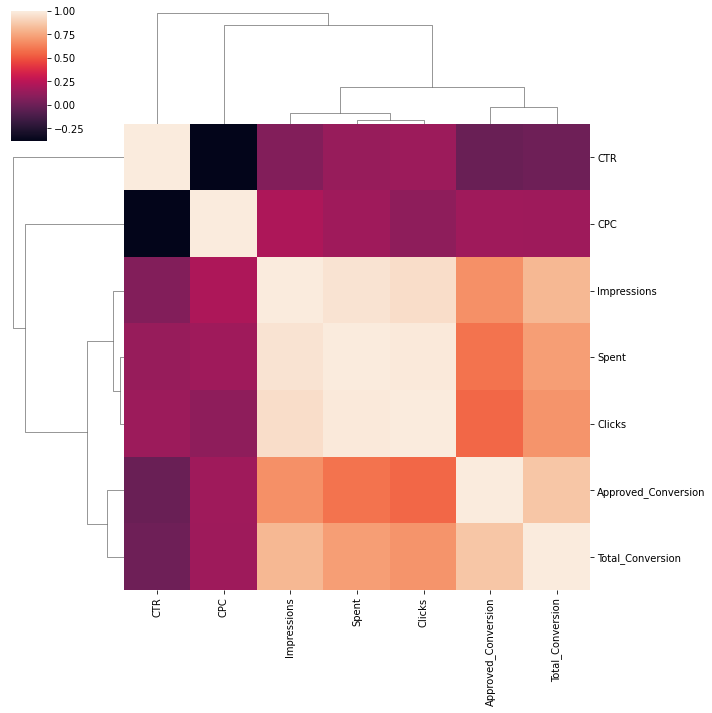

In [40]:
p1 = sns.clustermap(subset_df.corr())
p1.savefig('/content/drive/My Drive/Colab Notebooks/831/data/plot1.png')

We can also visualize the correlation numerically as following

In [41]:
corr = subset_df.corr(method='pearson')#.style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)
corr

,CTR,CPC,Approved_Conversion,Total_Conversion,Impressions,Spent,Clicks
CTR,1.000000,-0.378854,-0.006602,0.010721,0.075914,0.140952,0.159290
CPC,-0.378854,1.000000,0.170040,0.160828,0.208556,0.165464,0.112676
Approved_Conversion,-0.006602,0.170040,1.000000,0.864034,0.684249,0.593178,0.559526
Total_Conversion,0.010721,0.160828,0.864034,1.000000,0.812838,0.725379,0.694632
Impressions,0.075914,0.208556,0.684249,0.812838,1.000000,0.970386,0.948514
Spent,0.140952,0.165464,0.593178,0.725379,0.970386,1.000000,0.992906
Clicks,0.159290,0.112676,0.559526,0.694632,0.948514,0.992906,1.000000


In [42]:
from matplotlib import pyplot as plt

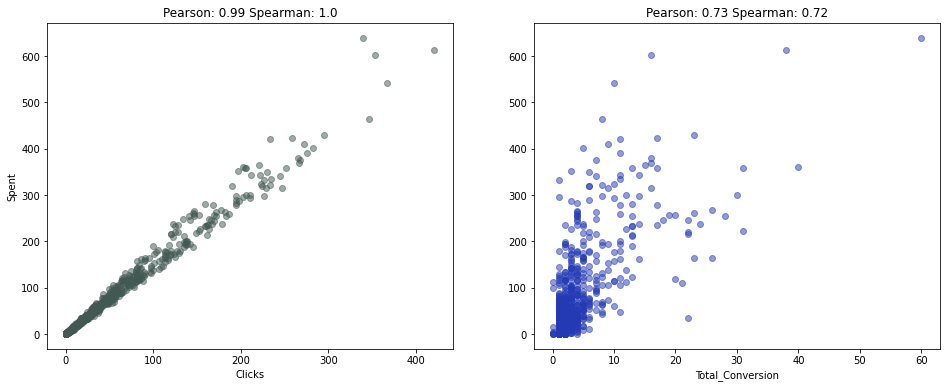

In [43]:
# plot correlated values
plt.rcParams['figure.figsize'] = [16, 6]

fig, ax = plt.subplots(nrows=1, ncols=2)

ax=ax.flatten()

cols = ['Clicks','Total_Conversion']
colors=['#415952', '#243AB5']#, '#243AB5','#243AB5']
j=0

for i in ax:
    if j==0:
        i.set_ylabel('Spent')
    i.scatter(subset_df[cols[j]], subset_df['Spent'],  alpha=0.5, color=colors[j])
    i.set_xlabel(cols[j])
    i.set_title('Pearson: %s'%subset_df.corr().loc[cols[j]]['Spent'].round(2)+' Spearman: %s'%subset_df.corr(method='spearman').loc[cols[j]]['Spent'].round(2))
    j+=1

plt.savefig('/content/drive/My Drive/Colab Notebooks/831/data/plot2.png')
plt.show()

<font color='orange'>It is reassuring that the higher the spend, the more clicks and although less reliably, the more conversions.</font> However, in order to be able to provide an improvement in the desired business performance, in this case maximising revenue, actionable insights have to be obtained. The data is broken down into different campaigns, which will need to be analysed in turn.

Before that, we have to introduce both 'CTR' and 'CPC' into the subset copy.

In [44]:
subset_df_2 = df[['xyz_campaign_id', 'CTR', 'CPC', 'Approved_Conversion', 'Total_Conversion', 'Impressions', 'Spent', 'Clicks']].copy()

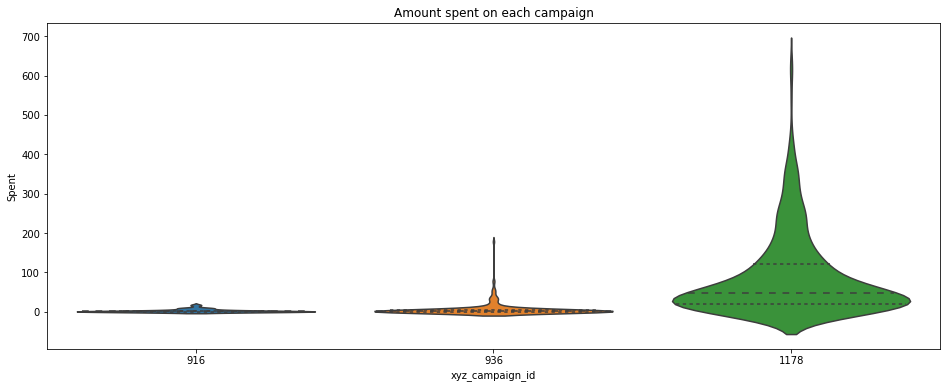

In [45]:
# plot correlated values
plt.rcParams['figure.figsize'] = [16, 6]

fig, ax = plt.subplots(nrows=1, ncols=1)

#ax=ax.flatten()

cols = ['xyz_campaign_id']
colors=['#415952']#, '#243AB5','#243AB5']
j=0

#for i in ax:
if j==0:
    ax.set_ylabel('Spent')
#ax.scatter(subset_df_2[cols[j]], subset_df_2['Spent'],  alpha=0.5, color=colors[j])
sns.violinplot(x='xyz_campaign_id', y='Spent', data=subset_df_2, scale='width', inner='quartile')
ax.set_xlabel(cols[j])
ax.set_title('Amount spent on each campaign')
j+=1

plt.savefig('/content/drive/My Drive/Colab Notebooks/831/data/plot3.png')
plt.show()

The above figure shows <font color='orange'>campaign 916 has the least spend</font>, so this is the one that will be focussed on further.

# Deep dive into specific campaign <font color='orange'>916</font>

In [46]:
cam_df = df.drop(df[(df.xyz_campaign_id != 916)].index)

## Checking missing values

The amount of missing data was checked, as shown in the table below which shows the percentage of missing data for each variable. Missing values are only present for the CPC variable, where clicks and spent equal 0, returning NAN.

In [47]:
columns = cam_df.columns
percentage_missing = cam_df.isnull().sum() * 100 / len(cam_df)
table_percentage_missing = pd.DataFrame({'column_name': columns,
                                 'percentage_missing': percentage_missing})

table_percentage_missing

,column_name,percentage_missing
ad_id,ad_id,0.000000
xyz_campaign_id,xyz_campaign_id,0.000000
fb_campaign_id,fb_campaign_id,0.000000
age,age,0.000000
gender,gender,0.000000
interest,interest,0.000000
Impressions,Impressions,0.000000
Clicks,Clicks,0.000000
Spent,Spent,0.000000
Total_Conversion,Total_Conversion,0.000000


## Checking demographics distribution

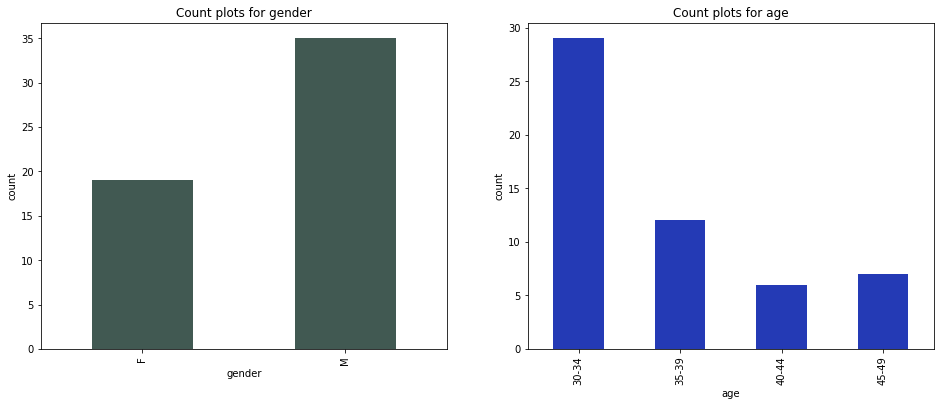

In [48]:
# plot demographics distribution
plt.rcParams['figure.figsize'] = [16, 6]

fig, ax = plt.subplots(nrows=1, ncols=2)

ax=ax.flatten()

cols = ['gender','age']
colors=['#415952', '#243AB5']#, '#243AB5','#243AB5']
j=0

for i in ax:
    i.set_ylabel('count')     
    cam_df[cols[j]].value_counts()[:].sort_index(ascending=True).plot(kind='bar', color=colors[j], ax=i)
    i.set_xlabel(cols[j])
    i.set_title('Count plots for %s'%cols[j])
    j+=1

plt.savefig('/content/drive/My Drive/Colab Notebooks/831/data/plot4-916.png')
plt.show()

It shows basic count distributions for gender and age subgroups. There is <font color='orange'>no overwhelming unbalanced contributions</font> to these subgroups

## Further feature engineering

When the business aim is to <font color='orange'>maximise revenue for advertising expenditure</font>, the ROAS metric is very useful. However, this requires the monetary amounts from conversions (Total_conversion) and sales (Approved_conversion) be known. In the following it is a assumed the former is worth <font color='orange'>CAD 10</font> and the later <font color='orange'>CAD 200</font> (<font color='red'>TBC?</font>). Using this the 

---

other metrics were calculated and the resulting dataframe head shown below.

In [49]:
cam_df['totConv'] = cam_df.loc[:,'Total_Conversion'] + cam_df.loc[:,'Approved_Conversion']
cam_df['conVal'] = cam_df['Total_Conversion'] * 10
cam_df['appConVal'] = cam_df['Approved_Conversion'] * 200
cam_df['totConvVal'] = cam_df['conVal'] + cam_df['appConVal']
cam_df['costPerCon'] = round(cam_df['Spent'] / cam_df['totConv'], 2)
cam_df['ROAS'] = round(cam_df['totConvVal'] / cam_df['Spent'], 2)
cam_df['CPM'] = round((cam_df['Spent'] / cam_df['Impressions']) * 1000, 2)

In [50]:
cam_df.head()

,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion,CTR,CPC,totConv,conVal,appConVal,totConvVal,costPerCon,ROAS,CPM
0,708746,916,103916,30-34,M,15,7350,1,1.43,2,1,0.013605,1.43,3,20,200,220,0.48,153.85,0.19
1,708749,916,103917,30-34,M,16,17861,2,1.82,2,0,0.011198,0.91,2,20,0,20,0.91,10.99,0.10
2,708771,916,103920,30-34,M,20,693,0,0.00,1,0,0.000000,NaN,1,10,0,10,0.00,inf,0.00
3,708815,916,103928,30-34,M,28,4259,1,1.25,1,0,0.023480,1.25,1,10,0,10,1.25,8.00,0.29
4,708818,916,103928,30-34,M,28,4133,1,1.29,1,1,0.024195,1.29,2,10,200,210,0.64,162.79,0.31


In [62]:
cam_df[["CTR","CPC","Approved_Conversion"]].mean()

CTR                    0.018015
CPC                    1.330350
Approved_Conversion    0.444444
dtype: float64

ROAS of infinity occurs when there are 0 clicks but a conversion. This may have happened because the click wasn't tracked or it occurred at a different time and has been attributed elsewhere. Convert these values to NAN and check for missing data.

Check that this data change now shows up in missing data count.

In [51]:
import numpy as np

In [52]:
columns = cam_df.columns
# replace() infs with NaN: 
cam_df.replace([np.inf, -np.inf], np.nan, inplace=True)
percentage_missing = cam_df.isnull().sum() * 100 / len(cam_df)
table_percentage_missing = pd.DataFrame({'column_name': columns,
                                 'percentage_missing': percentage_missing})

table_percentage_missing

,column_name,percentage_missing
ad_id,ad_id,0.000000
xyz_campaign_id,xyz_campaign_id,0.000000
fb_campaign_id,fb_campaign_id,0.000000
age,age,0.000000
gender,gender,0.000000
interest,interest,0.000000
Impressions,Impressions,0.000000
Clicks,Clicks,0.000000
Spent,Spent,0.000000
Total_Conversion,Total_Conversion,0.000000


## Analysis by age, gender and interest

In order to improve a similar campaign with a view to maximising revenue return, the variables available in the dataset (in this case age, gender and interest) can be investigated further with respect to the ROAS metric.



### Analysis by gender

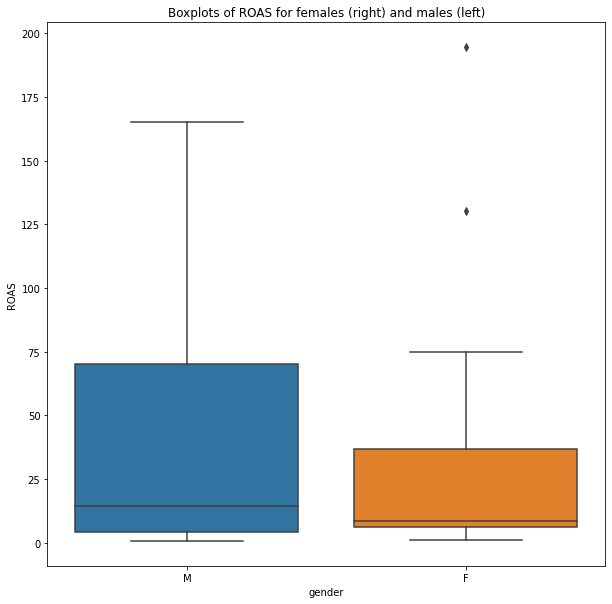

In [53]:
# plot gender against ROAS
plt.rcParams['figure.figsize'] = [10, 10]

fig, ax = plt.subplots(nrows=1, ncols=1)
#ax=ax.flatten()

cols = ['gender']
colors=['#415952']#, '#243AB5','#243AB5']
j=0

#for i in ax:
if j==0:
    ax.set_ylabel('ROAS')
#ax.scatter(subset_df_2[cols[j]], subset_df_2['Spent'],  alpha=0.5, color=colors[j])
sns.boxplot(x='gender', y='ROAS', data=cam_df, notch=False)
ax.set_xlabel(cols[j])
ax.set_title('Boxplots of ROAS for females (right) and males (left)')
#ax.set_yscale('log')
j+=1

plt.savefig('/content/drive/My Drive/Colab Notebooks/831/data/plot5-916.png')
plt.show()

In time, the ROAS is more likely to tend towards the mean, hence this is used subsequently.

*   Females mean ROAS 11.62
*   Males mean ROAS 16.51

It appears that the <font color='orange'>ROAS is highly dependant on gender</font> and therefore needs to be taken into account when interest and age are considered.


###Analysis by interest

The data is grouped by interest and the median, mean and sum of clicks calculated for each group, with the resulting dataframe sorted by ROAS mean descendingly.

In [54]:
grouped_interest = cam_df.groupby('interest').agg({'ROAS':['median','mean'],'Clicks':'sum'}) 
grouped_interest.columns = ['_'.join(x) for x in grouped_interest.columns.ravel()]
grouped_interest = grouped_interest.sort_values(by='ROAS_mean', ascending=0)
grouped_interest

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  


,ROAS_median,ROAS_mean,Clicks_sum
interest,,,
21,137.250,137.250000,1
32,130.430,130.430000,1
28,8.000,57.983333,5
15,6.620,53.630000,10
29,46.370,46.370000,9
16,11.620,41.814545,57
27,40.835,40.835000,3
10,36.650,36.650000,4
30,17.540,17.540000,1


Although ROAS mean is the metric being used, it is important to take into account the statistical significance of that value. This can be done very approximately by considering the sum of clicks, <font color='orange'>with a higher sum of clicks for a given interest group making it more likely the calculated ROAS metric is reliable, given the higher population.</font> Given this, <font color='orange'>interest groups 16, 15</font> and <font color='orange'>28</font> are considered further.

In [55]:
newdf_grouped_interest = cam_df[(cam_df['interest'] == 28) | (cam_df['interest'] == 15) | (cam_df['interest'] == 16)]
newdf_grouped_interest.head()

,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion,CTR,CPC,totConv,conVal,appConVal,totConvVal,costPerCon,ROAS,CPM
0,708746,916,103916,30-34,M,15,7350,1,1.43,2,1,0.013605,1.43,3,20,200,220,0.48,153.85,0.19
1,708749,916,103917,30-34,M,16,17861,2,1.82,2,0,0.011198,0.91,2,20,0,20,0.91,10.99,0.10
3,708815,916,103928,30-34,M,28,4259,1,1.25,1,0,0.023480,1.25,1,10,0,10,1.25,8.00,0.29
4,708818,916,103928,30-34,M,28,4133,1,1.29,1,1,0.024195,1.29,2,10,200,210,0.64,162.79,0.31
6,708889,916,103940,30-34,M,15,15615,3,4.77,1,0,0.019212,1.59,1,10,0,10,4.77,2.10,0.31


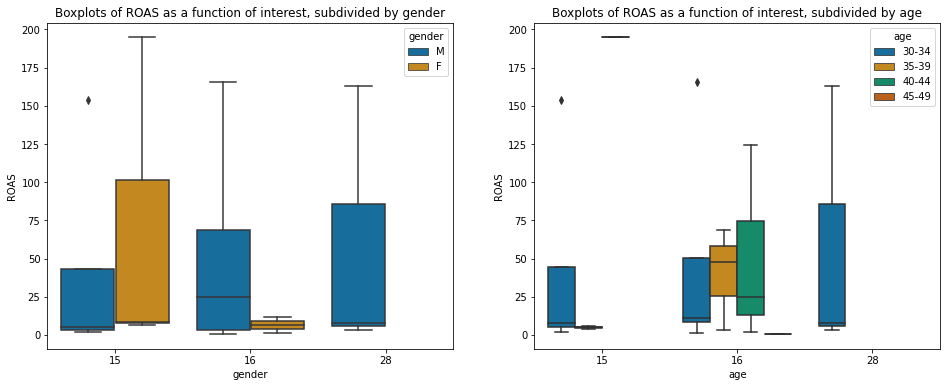

In [56]:
# plot demographics distribution
plt.rcParams['figure.figsize'] = [16, 6]

fig, ax = plt.subplots(nrows=1, ncols=2)

ax=ax.flatten()

cols = ['gender','age']
colors=['#415952', '#243AB5']#, '#243AB5','#243AB5']
j=0

for i in ax:
    i.set_ylabel('ROAS')     
    sns.boxplot(y='ROAS', x='interest', 
                 data=newdf_grouped_interest, 
                 palette="colorblind",
                 hue=cols[j],
                 ax=i)
    i.set_xlabel(cols[j])
    i.set_title('Boxplots of ROAS as a function of interest, subdivided by %s'%cols[j])
    j+=1

plt.savefig('/content/drive/My Drive/Colab Notebooks/831/data/plot6-916.png')
plt.show()

These plots indicate that focussing on <font color='orange'>males with interest group 16 in the age group 35-39 would be most beneficial to maximising ROAS</font>. However, these plots don't take into account number of clicks for each subgroup, so this is investigated in the following.

In [57]:
#grouped_gender = cam_df.groupby(['interest','gender']).agg({'ROAS':['median','mean'],'Clicks':'sum'}) 
grouped_interest_gender = newdf_grouped_interest.groupby(['interest','gender']).agg({'ROAS':['median','mean'],'Clicks':'sum'}) 
# Using ravel, and a string join, we can create better names for the columns:
grouped_interest_gender.columns = ['_'.join(x) for x in grouped_interest_gender.columns.ravel()]

grouped_interest_gender = grouped_interest_gender.sort_values(by='ROAS_mean', ascending=False)
grouped_interest_gender

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  after removing the cwd from sys.path.


,,ROAS_median,ROAS_mean,Clicks_sum
interest,gender,,,
15,F,8.400,69.903333,3
28,M,8.000,57.983333,5
16,M,24.790,49.695556,36
15,M,4.875,41.425000,7
16,F,6.350,6.350000,21


<font color='orange'>When considering interest and gender</font>, the table above suggests it might be beneficial to focus more on males with interest in group 16. However, the small number of clicks indicate this high ROAS result could be chance. <font color='orange'>Overall, when each of the interest groups 16, 15 and 28 are considered, more return is generated from males</font>.

In [58]:
#grouped_gender = cam_df.groupby(['interest','gender']).agg({'ROAS':['median','mean'],'Clicks':'sum'}) 
grouped_interest_age = newdf_grouped_interest.groupby(['interest','age']).agg({'ROAS':['median','mean'],'Clicks':'sum'}) 
# Using ravel, and a string join, we can create better names for the columns:
grouped_interest_age.columns = ['_'.join(x) for x in grouped_interest_age.columns.ravel()]

grouped_interest_age = grouped_interest_age.sort_values(by='ROAS_mean', ascending=False)
grouped_interest_age

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  after removing the cwd from sys.path.


ROAS_median   ROAS_mean  Clicks_sum
interest age                                       
15       40-44      194.690  194.690000           1
28       30-34        8.000   57.983333           5
16       40-44       24.790   50.286667          13
         30-34       11.305   47.260000          24
15       30-34        7.510   42.742500           6
16       35-39       47.520   39.810000           8
15       35-39        4.875    4.875000           3
16       45-49        0.630    0.630000          12

<font color='orange'>When considering interest and age</font>, the table above suggests it might be beneficial to focus more on people in the 30-34 age group with interest in group 16. However, again, the small number of clicks indicate this high ROAS result could be chance. <font color='orange'>The group with interest group 15 and age group 30-34 still has a high ROAS but also has much more substantial clicks sum.</font>



### Analysis by age

Similarly, we grouped the data by age and the median, mean and sum of clicks calculated for each group, with the resulting dataframe sorted by ROAS mean descendingly.

In [59]:
grouped_age = cam_df.groupby('age').agg({'ROAS':['median','mean'],'Clicks':'sum'}) 
# Using ravel, and a string join, we can create better names for the columns:
grouped_age.columns = ['_'.join(x) for x in grouped_age.columns.ravel()]

grouped_age = grouped_age.sort_values(by='ROAS_mean', ascending=0)
grouped_age.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  This is separate from the ipykernel package so we can avoid doing imports until


,ROAS_median,ROAS_mean,Clicks_sum
age,,,
40-44,74.525,86.387500,14
30-34,10.990,43.102353,57
45-49,6.800,36.480000,25
35-39,8.200,32.122222,17


The table above again suggests focussing on the 30-34 age group. Again the 30-34 age group is highlighted, particularly for males and for the interest group 101.

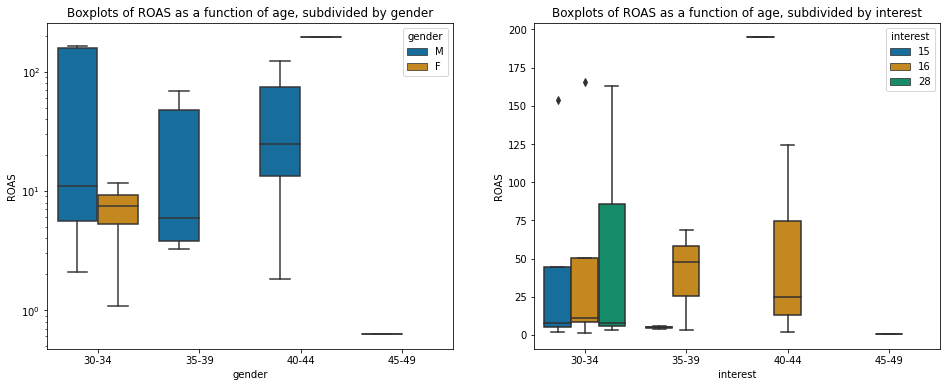

In [60]:
# plot demographics distribution
plt.rcParams['figure.figsize'] = [16, 6]

fig, ax = plt.subplots(nrows=1, ncols=2)

ax=ax.flatten()

cols = ['gender','interest']
colors=['#415952', '#243AB5']#, '#243AB5','#243AB5']
j=0

for i in ax:
    i.set_ylabel('ROAS')     
    sns.boxplot(y='ROAS', x='age', 
                 data=newdf_grouped_interest, 
                 palette="colorblind",
                 hue=cols[j],
                 ax=i)
    i.set_xlabel(cols[j])
    i.set_title('Boxplots of ROAS as a function of age, subdivided by %s'%cols[j])
    if j == 0:
      i.set_yscale('log')
    j+=1

plt.savefig('/content/drive/My Drive/Colab Notebooks/831/data/plot7-916.png')
plt.show()

In [61]:
grouped_age_gender = cam_df.groupby(['age','gender']).agg({'ROAS':['median','mean'],'Clicks':'sum'}) 
grouped_age_gender.columns = ['_'.join(x) for x in grouped_age_gender.columns.ravel()]
grouped_age_gender = grouped_age_gender.sort_values(by='ROAS_mean', ascending=False)
grouped_age_gender

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  


ROAS_median   ROAS_mean  Clicks_sum
age   gender                                     
40-44 F           194.690  194.690000           1
30-34 M            14.265   55.088000          21
40-44 M            24.790   50.286667          13
45-49 M             6.800   48.226667          14
35-39 M            26.720   33.275000          13
      F             8.200   29.816667           4
30-34 F             8.400   25.980000          36
45-49 F            18.860   18.860000          11

Grouping by gender in addition verifies that the group age group 30-34 is most important to focus on. <font color='orange'>The least effective age group to focus on would be the 45-49 age group</font>. The gender split in performance accross age groups is less apparent than which was observed for interests.



### Analysis by age, gender and interest (<font color='red'>TBC</font>)

# Conclusions

This project has been an exploratory data analysis using facebook ad data. It has assumed business performance is determined by absolute return and as such the ROAS metric has been used to try and identify how to generate better performance had a similar campaign been run. <font color='orange'>Sum of clicks for each group identified was also used as an approximate indicator of the validity of the mean ROAS measured</font>. The findings indicate a similar campaign should:

* focus on the 30-34 age group.
* focus on males.
* focus on groups with interests 16, 15 and 28.

The campaign is <font color='orange'>least effective</font> when focussing on:

* the 45-49 age group.

In further work the significance of these findings should be investigated.
